# Object Detection

<a name='0'></a>
## Packages


In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_class_probs*box_confidence

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    # IMPORTANT: set axis to -1
    box_classes = tf.math.argmax(box_scores, axis = -1) # stores the index
    box_class_scores = tf.math.reduce_max(box_scores, axis = -1 ) # stores the score
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE
    
    return scores, boxes, classes

In [4]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)

In [5]:
box_confidence

<tf.Tensor: shape=(19, 19, 5, 1), dtype=float32, numpy=
array([[[[ 0.885695  ],
         [ 1.6324562 ],
         [-1.0968447 ],
         [-1.3350451 ],
         [ 1.3657959 ]],

        [[-6.310956  ],
         [-0.54382193],
         [-0.24732351],
         [-3.580883  ],
         [-3.31002   ]],

        [[ 0.54773545],
         [ 4.758901  ],
         [ 1.6720673 ],
         [ 4.213396  ],
         [-1.2036383 ]],

        ...,

        [[ 4.80858   ],
         [ 3.7966952 ],
         [-1.3533506 ],
         [-6.822542  ],
         [-3.4974623 ]],

        [[-1.2262459 ],
         [ 4.4115167 ],
         [ 8.742956  ],
         [ 2.0873146 ],
         [ 2.3414388 ]],

        [[ 4.7560472 ],
         [-0.59531415],
         [ 4.8122883 ],
         [-6.9828544 ],
         [ 1.8264282 ]]],


       [[[ 2.0660179 ],
         [-1.6790407 ],
         [ 7.8485665 ],
         [-0.64332736],
         [ 4.379981  ]],

        [[ 1.1363745 ],
         [-6.796674  ],
         [ 1.6406859 ],
  

In [6]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


In [8]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    ### START CODE HERE
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,yi2 - yi1)
    inter_height = max(0,xi2 - xi1)
    inter_area = inter_width*inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    ### END CODE HERE
    
    return iou

In [9]:
# BEGIN UNIT TEST
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(iou(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")
# END UNIT TEST

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
 All tests passed!


In [11]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

In [12]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

assert type(scores) == EagerTensor, "Use tensoflow functions"
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 8.147684), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [ 6.0797963, 3.743308, 1.3914018, -0.34089637]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 1.7079165), "Wrong value on classes"

print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.743308    1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


In [13]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [14]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape) # Network was trained to run on 608x608 images
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

In [15]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"
    
assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"
    
print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


In [16]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [27]:
anchors

array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

In [28]:
class_names

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

<a name='3-2'></a>
###  Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

Run the cell below to load the model from this file.

In [17]:
yolo_model = load_model("model_data/", compile=False)

This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains:

In [18]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 10 boxes for images/test2.jpg
car 0.73 (156, 124) (188, 154)
car 0.65 (204, 114) (227, 137)
car 0.64 (161, 104) (184, 122)
car 0.63 (214, 175) (250, 204)
car 0.61 (158, 154) (198, 190)
car 0.57 (212, 145) (243, 170)
traffic light 0.45 (202, 25) (213, 33)
traffic light 0.37 (126, 25) (132, 33)
car 0.35 (190, 71) (213, 96)
car 0.33 (119, 62) (146, 82)


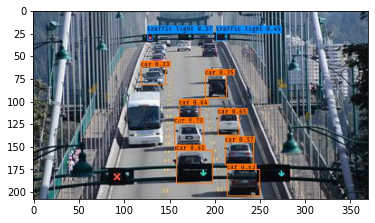

In [21]:
out_scores, out_boxes, out_classes = predict("test2.jpg")

<a name='5'></a>
## 5 - References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 
